    -Обучить полносвязную модель на MNIST
    -Обучить глубокую сверточную сеть на MNIST
    -*обучить с нуля глубокую сеть на небольшом датасете. Сравнить результат с дообучением передобученной сети

In [4]:
#пайплайн для того, чтобы что-то обучить:
# архитектура модели +
# загрузчик данных +
# формирование батча +
# оптимизатор +
# функция потерь +
# опционально шедулеры - (повышать или понижать lr)
# трейн луп или цикл обучения

In [1]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

<style>
mark{
    background-color: red
}
</style>
<mark>1. Обучить полносвязную модель на MNIST:</mark>




<style>
mark{
    background-color: red
}
</style>
<mark>Архитектура модели:</mark>


In [3]:
class LinearModel(nn.Module):                               # наследуемся от nn.Module
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.2):
        super().__init__()                                  # инициализация родителя
        self.linear1 = nn.Linear(input_dim, hidden_dim) #1-й слой принимает некот.входную размерность input_dim  и отображает её в hidden_dim
        nn.init.xavier_normal_(self.linear1.weight)         
        self.activation1 = nn.Sigmoid()
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)    # вход след слоя должен равняться выходу предыдущего
        self.activation2 = nn.Sigmoid()
        self.do2 = nn.Dropout(dropout_p)
        self.linear3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):                                   # на форвард приходят фичи x - картинка, вытянутая в вектор
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.do1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.do2(x)
        x = self.linear3(x)     

        return x

<style>
mark{
    background-color: red
}
</style>
<mark>Загрузчик данных:</mark>



In [5]:
# скачивание обучающего датасета
dataset_train = datasets.MNIST('.', train=True, download=True)

# скачивание тестового датасета
dataset_test = datasets.MNIST('.', train=False, download=True)

In [7]:
#смотрим, что у нас в датасете: это кортеж,который состоит из картинки и метки, что это 5

In [9]:
dataset_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

<style>
mark{
    background-color: red
}
</style>
<mark>Формирование батча:</mark>



In [13]:
def collate_fn(data: list):                             # из списка обучающих примеров формирует нам готовый для обучения батч
  # data = [(pic, target)...]                           # это картинка и target-лейбл.Нам нужно сформировать из них батч
                                                    #collate_fn разбирает кортеж: картинки складывает в "picх", targetы складывает в "target"
                                                        #и выводит нам словарик 'data' и 'target'
  pics = []
  target = []

  # в цикле формируются списки с картинками и таргетами для каждого индекса, поданного на вход 
  for item in data:                
    pics.append(numpy.array(item[0]))
    target.append(item[1])    

  # картинки преобразовываются в торчтензор, который имеет размер батч x ширина x высота
  # нормирование данных (интенсивность 0-255 приводится к 0-1)  
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1),              # происходит вытягивание картинок в вектор
      'target': target,                                 # преобразуем матрицу 28х28 в вектор 784 (линейный слой не работает с матрицами)
      }


<style>
mark{
    background-color: red
}
</style>
<mark>Оптимизатор:</mark>


In [14]:
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'mps' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 20
batch_size = 128


<style>
mark{
    background-color: red
}
</style>
<mark> Инициализация модели, задание оптимизатора и функции потерь:</mark>


In [19]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters()) # Adam с параметрами по умолчанию
loss_func = nn.CrossEntropyLoss()   # функция потерь CrossEntropyLoss (для многоклассовой классификации)

In [20]:
# для каждой эпохи
for epoch in range(n_epochs):
    
    # случайное разбиение обучающей выборки на батчи
    trainloader = DataLoader(dataset_train, 
                             batch_size,
                             shuffle=True, 
                             collate_fn=collate_fn, 
                             drop_last = True)
    
    # перевод модель в режим обучения
    model.train()
    # итератор по батчам (у метода DataLoader)
    for i, batch in enumerate(trainloader):
        # обнуление градиентов (в торче они накапливаются с каждым бэквордом)
        optim.zero_grad()
        # передача в модель батча - выполнение предсказания
        predict = model(batch['data'].to(device))
        # расчет функции потерь (по предсказанию и таргету батча)
        loss = loss_func(predict, batch['target'].to(device))
        # расчет градиентов (в торче работает autograd)
        loss.backward()
        # обновление весов (встроенный в оптимизатор метод)
        optim.step()
        # каждые 200 шагов выводим статистику по модели
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss_dataset_train: {loss.item()}')
    
    # случайное разбиение тестовой выборки на батчи
    testloader = DataLoader(dataset_test, 
                            batch_size=len(dataset_test.data),
                            shuffle=True, 
                            collate_fn=collate_fn, 
                            drop_last = False)
    
    # перевод модель в режим инференса
    model.eval()
    for i, batch in enumerate(testloader):
        # передача в модель батча (батч 1) - выполнение предсказания        
        predict = model(batch['data'].to(device))
        # расчет функции потерь (по предсказанию и таргету батча)
        loss = loss_func(predict, batch['target'].to(device))
        # выводим loss по тестовой выборке
        print(f'epoch: {epoch}, loss_dataset_test: {loss.item()}')
        print()

epoch: 0, step: 0, loss_dataset_train: 2.2919769287109375
epoch: 0, step: 200, loss_dataset_train: 0.43682172894477844
epoch: 0, step: 400, loss_dataset_train: 0.29273897409439087
epoch: 0, loss_dataset_test: 0.27486464381217957

epoch: 1, step: 0, loss_dataset_train: 0.26610028743743896
epoch: 1, step: 200, loss_dataset_train: 0.20576508343219757
epoch: 1, step: 400, loss_dataset_train: 0.159579798579216
epoch: 1, loss_dataset_test: 0.19716010987758636

epoch: 2, step: 0, loss_dataset_train: 0.25109297037124634
epoch: 2, step: 200, loss_dataset_train: 0.3450363874435425
epoch: 2, step: 400, loss_dataset_train: 0.19798389077186584
epoch: 2, loss_dataset_test: 0.15459519624710083

epoch: 3, step: 0, loss_dataset_train: 0.18133874237537384
epoch: 3, step: 200, loss_dataset_train: 0.209319606423378
epoch: 3, step: 400, loss_dataset_train: 0.1998668909072876
epoch: 3, loss_dataset_test: 0.12914840877056122

epoch: 4, step: 0, loss_dataset_train: 0.09219477325677872
epoch: 4, step: 200, los

Loss для тестовой выборки больше, чем для обучающей (что логично для распознавания картинок линейным слоем)

<style>
mark{
    background-color: red
}
</style>
<mark> 
Посмотрим результаты предсказания на обучающей выборке и на тестовой выборках:</mark>


In [21]:
# Функция вывода по номеру элемента (может быть случайным) изображения предсказанного и реального значения
def result(train_or_test, n_item=None):
    if train_or_test == "train":
        if n_item == None:
            n_item = torch.randint(0, len(dataset_train)-1, (1, 1)).squeeze().tolist()
        else:
            n_item = n_item
        image = dataset_train.data[n_item].detach().numpy()
        data = dataset_train.data[n_item].unsqueeze(0).view(1, -1).to(device).float()
        target = dataset_train.targets[n_item].tolist()
        print(f"Обучающая выборка, элемент № {n_item}")
    elif train_or_test == "test":
        if n_item == None:
            n_item = torch.randint(0, len(dataset_test)-1, (1, 1)).squeeze().tolist()
        else:
            n_item = n_item
        image = dataset_test.data[n_item].detach().numpy()
        data = dataset_test.data[n_item].unsqueeze(0).view(1, -1).to(device).float()
        target = dataset_test.targets[n_item].tolist()
        print(f"Тестовая выборка, элемент № {n_item}")
    else:
        print("Нужно указать датасет: 'train' или 'test'") 
    if train_or_test == "train" or train_or_test == "test":       
        model.eval()
        plt.imshow(image)
        plt.show()
        predict = torch.argmax(model(data)).squeeze().cpu().detach().tolist()
        print(f"predict: {predict}")
        print(f"true:    {target}")

Обучающая выборка, элемент № 48255


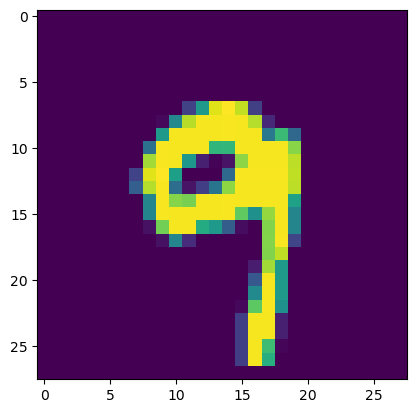

predict: 9
true:    9


In [22]:
result('train')

Тестовая выборка, элемент № 9778


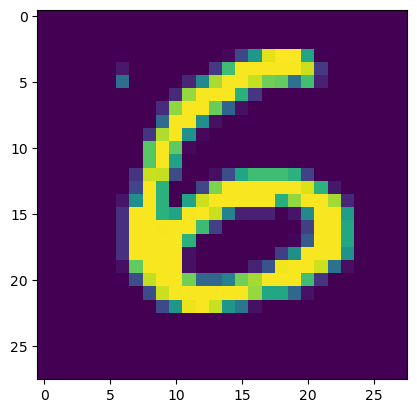

predict: 6
true:    6


In [23]:
result('test')


<style>
mark{
    background-color: red
}
</style>
<mark> 
2. Обучить глубокую сверточную сеть на MNIST:</mark>



<style>
mark{
    background-color: red
}
</style>
<mark> 
Архитектура модели:</mark>


In [24]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.2):
    super().__init__()
    # уменьшит размер картинки в 2 раза
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2) # число каналов на входе 
                                                                                    # число каналов на выходе
                                                                                    # размер ядра, размер паддинга и страйд
    self.bn1 = nn.BatchNorm2d(hidden_ch)                                            # батчнорм от предыдущего выхода
    self.activation1 = nn.Sigmoid()
    self.do1 = nn.Dropout(dropout_p)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.activation2 = nn.Sigmoid()    
    self.do2 = nn.Dropout(dropout_p)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.activation3 = nn.Sigmoid()    
    self.do3 = nn.Dropout(dropout_p)     
    self.conv4 = nn.Conv2d(hidden_ch, 15, kernel_size=3, padding=1, stride=1)        # на выходе 5 каналов
    self.classifier = nn.Linear(15 * 14 *14, output_dim)                             # на входе классификатора 5 каналов


  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation1(x)
    x = self.do1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation2(x)
    x = self.do2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.activation3(x)
    x = self.do3(x)
    x = self.conv4(x)
    x = self.classifier(x.view(x.size(0), -1))  # на вход классификатора подаются batch_size векторов

    return x

<style>
mark{
    background-color: red
}
</style>
<mark> 
Загрузчикд данных </mark>
остаётся тот же


<style>
mark{
    background-color: red
}
</style>
<mark> 
Формирование батча </mark>

In [26]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      # метод unsqueeze добавляет метод измерения в тензоре
      # сверточный слой ждет число каналов (изображения подаются поканально)
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

Киберпараметры:

In [27]:
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'mps' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 30
batch_size = 128

<style>
mark{
    background-color: red
}
</style>
<mark> Инициализация модели, задание оптимизатора и функции потерь:</mark>


In [28]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [29]:
# для каждой эпохи
for epoch in range(n_epochs):
    
    # случайное разбиение обучающей выборки на батчи
    trainloader = DataLoader(dataset_train, 
                             batch_size,
                             shuffle=True, 
                             collate_fn=collate_fn_conv, 
                             drop_last = True)
    
    # перевод модель в режим обучения
    model_conv.train()
    # итератор по батчам (у метода DataLoader)
    for i, batch in enumerate(trainloader):
        # обнуление градиентов (в торче они накапливаются с каждым бэквордом)
        optim.zero_grad()
        # передача в модель батча - выполнение предсказания
        predict = model_conv(batch['data'].to(device))
        # расчет функции потерь (по предсказанию и таргету батча)
        loss = loss_func(predict, batch['target'].to(device))
        # расчет градиентов (в торче работает autograd)
        loss.backward()
        # обновление весов (встроенный в оптимизатор метод)
        optim.step()
        # каждые 200 шагов выводим статистику по модели
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss_dataset_train: {loss.item()}')
    
    # случайное разбиение тестовой выборки на батчи
    testloader = DataLoader(dataset_test, 
                            batch_size=len(dataset_test.data),
                            shuffle=True, 
                            collate_fn=collate_fn_conv, 
                            drop_last = False)
    
    # перевод модель в режим инференса
    model_conv.eval()
    for i, batch in enumerate(testloader):
        # передача в модель батча (батч 1) - выполнение предсказания        
        predict = model_conv(batch['data'].to(device))
        # расчет функции потерь (по предсказанию и таргету батча)
        loss = loss_func(predict, batch['target'].to(device))
        # выводим loss по тестовой выборке
        print(f'epoch: {epoch}, loss_dataset_test: {loss.item()}')
        print()

epoch: 0, step: 0, loss_dataset_train: 2.334397077560425
epoch: 0, step: 200, loss_dataset_train: 0.5737944841384888
epoch: 0, step: 400, loss_dataset_train: 0.19787417352199554
epoch: 0, loss_dataset_test: 0.2735842764377594

epoch: 1, step: 0, loss_dataset_train: 0.31841403245925903
epoch: 1, step: 200, loss_dataset_train: 0.10988953709602356
epoch: 1, step: 400, loss_dataset_train: 0.1397686004638672
epoch: 1, loss_dataset_test: 0.10088557004928589

epoch: 2, step: 0, loss_dataset_train: 0.17355592548847198
epoch: 2, step: 200, loss_dataset_train: 0.05518880486488342
epoch: 2, step: 400, loss_dataset_train: 0.0887857973575592
epoch: 2, loss_dataset_test: 0.08623118698596954

epoch: 3, step: 0, loss_dataset_train: 0.10342980921268463
epoch: 3, step: 200, loss_dataset_train: 0.11309327185153961
epoch: 3, step: 400, loss_dataset_train: 0.17726311087608337
epoch: 3, loss_dataset_test: 0.06149950623512268

epoch: 4, step: 0, loss_dataset_train: 0.05011188983917236
epoch: 4, step: 200, lo

<style>
mark{
    background-color: red
}
</style>
<mark> 
Посмотрим результаты предсказания на обучающей выборке и на тестовой выборках:</mark>


In [32]:
# Функция вывода по номеру элемента (может быть случайным) изображения предсказанного и реального значения
def result(model, train_or_test, n_item=None):
    if train_or_test == "train":
        if n_item == None:
            n_item = torch.randint(0, len(dataset_train)-1, (1, 1)).squeeze().tolist()
        else:
            n_item = n_item
        image = dataset_train.data[n_item].detach().numpy()
        data = dataset_train.data[n_item].unsqueeze(0).unsqueeze(0).to(device).float()
        target = dataset_train.targets[n_item].tolist()
        print(f"Обучающая выборка, элемент № {n_item}")
    elif train_or_test == "test":
        if n_item == None:
            n_item = torch.randint(0, len(dataset_test)-1, (1, 1)).squeeze().tolist()
        else:
            n_item = n_item
        image = dataset_test.data[n_item].detach().numpy()
        #data = dataset_test.data[n_item].unsqueeze(0).view(1, -1).to(device).float()
        data = dataset_test.data[n_item].unsqueeze(0).unsqueeze(0).to(device).float()
        target = dataset_test.targets[n_item].tolist()
        print(f"Тестовая выборка, элемент № {n_item}")
    else:
        print("Нужно указать датасет: 'train' или 'test'") 
    if train_or_test == "train" or train_or_test == "test":       
        model.eval()
        plt.imshow(image)
        plt.show()
        predict = torch.argmax(model_conv(data)).squeeze().cpu().detach().tolist()
        print(f"predict: {predict}")
        print(f"true:    {target}")

Обучающая выборка, элемент № 42017


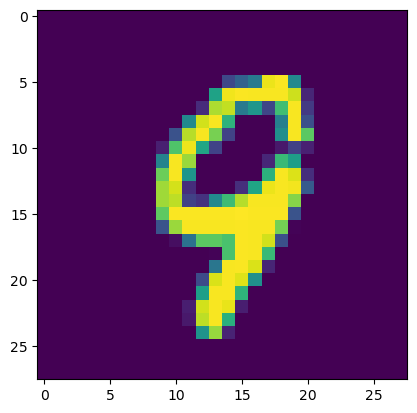

predict: 9
true:    9


In [33]:
result(model_conv, 'train')

Тестовая выборка, элемент № 3512


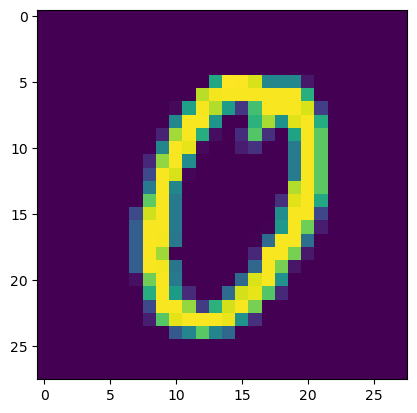

predict: 0
true:    0


In [34]:
result(model_conv, 'test')